# Neural Collaborative Filter - TensorFlow2

This code example demonstrates [Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k) to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a _user vector_ via an embedding matrix
2. Map movie ID to a _movie vector_ via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.


[Refer](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)

In [48]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding


import pandas as pd
import os
from zipfile import ZipFile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.3.0


In [7]:
# Use 'rarings.csv' file-
data_ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [8]:
data_ratings.shape

(100836, 4)

In [9]:
data_ratings.isna().values.any()

False

In [10]:
data_ratings.isna().sum().sum()

0

In [11]:
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
data_ratings['timestamp'] = pd.to_datetime(data_ratings['timestamp'])

In [15]:
data_ratings.sort_values(by = 'timestamp', ascending = True, inplace = True)

In [16]:
data_ratings.reset_index(drop = True, inplace = True)

In [17]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,429,595,5.0,1970-01-01 00:00:00.828124615
1,429,588,5.0,1970-01-01 00:00:00.828124615
2,429,590,5.0,1970-01-01 00:00:00.828124615
3,429,592,5.0,1970-01-01 00:00:00.828124615
4,429,432,3.0,1970-01-01 00:00:00.828124615


## Preprocess data to encode users and movies as integer incdices:

In [19]:
user_ids = data_ratings["userId"].unique().tolist()

In [21]:
print(f"number of users in dataset = {len(user_ids)}")

number of users in dataset = 610


In [22]:
# Create Python3 dicts where index is int and value is user ids-
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [23]:
type(user2user_encoded), type(userencoded2user)

(dict, dict)

In [26]:
# Sanity check-
user2user_encoded[10], userencoded2user[10]

(519, 145)

In [28]:
movie_ids = data_ratings["movieId"].unique().tolist()

In [29]:
print(f"number of movies in dataset = {len(movie_ids)}")

number of movies in dataset = 9724


In [30]:
# Create Python3 dicts where index is int and value is movie ids-
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [31]:
movie2movie_encoded[23], movie_encoded2movie[23]

(141, 266)

In [32]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,429,595,5.0,1970-01-01 00:00:00.828124615
1,429,588,5.0,1970-01-01 00:00:00.828124615
2,429,590,5.0,1970-01-01 00:00:00.828124615
3,429,592,5.0,1970-01-01 00:00:00.828124615
4,429,432,3.0,1970-01-01 00:00:00.828124615


In [33]:
# Create two new columns 'user' and 'movie'-
data_ratings["user"] = data_ratings["userId"].map(user2user_encoded)
data_ratings["movie"] = data_ratings["movieId"].map(movie2movie_encoded)

In [34]:
data_ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,429,595,5.0,1970-01-01 00:00:00.828124615,0,0
1,429,588,5.0,1970-01-01 00:00:00.828124615,0,1
2,429,590,5.0,1970-01-01 00:00:00.828124615,0,2
3,429,592,5.0,1970-01-01 00:00:00.828124615,0,3
4,429,432,3.0,1970-01-01 00:00:00.828124615,0,4


In [37]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
print(f"number of users = {num_users} and number of movies = {num_movies}")

data_ratings["rating"] = data_ratings["rating"].values.astype(np.float32)

# Normalize ratings using min and max ratings-
min_rating = min(data_ratings["rating"])
max_rating = max(data_ratings["rating"])

print(f"minimum rating = {min_rating} and maximum rating = {max_rating}")

number of users = 610 and number of movies = 9724
minimum rating = 0.5 and maximum rating = 5.0


In [39]:
# Get all movies getting a minimum rating of 0.5-
data_ratings.loc[data_ratings['rating'] == min_rating, 'movieId']

30029       5771
30030       4676
30031       1526
30033       4040
30036       2796
           ...  
100439    141994
100457    179819
100527    184641
100630    175475
100791      6534
Name: movieId, Length: 1370, dtype: int64

In [40]:
# Get all movies getting a minimum rating of 5-
data_ratings.loc[data_ratings['rating'] == max_rating, 'movieId']

0            595
1            588
2            590
3            592
15           161
           ...  
100810       608
100811     55820
100812     57669
100819    148671
100824    177765
Name: movieId, Length: 13211, dtype: int64

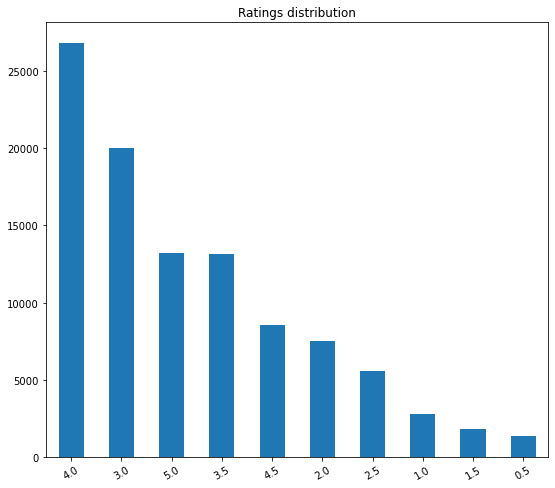

In [45]:
# Visualize distribution of ratings-
plt.figure(figsize = (9, 8))
data_ratings['rating'].value_counts().plot(kind = 'bar')
plt.title("Ratings distribution")
plt.xticks(rotation = 30)
plt.show()

In [46]:
# Prepare training and validation data:

data_ratings = data_ratings.sample(frac = 1)
x = data_ratings[["user", "movie"]].values

# Normalize the targets between 0 and 1 for better training-
y = data_ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%-
train_indices = int(0.9 * data_ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print(f"x_train.shape = {x_train.shape} & y_train.shape = {y_train.shape}")
print(f"x_val.shape = {x_val.shape} & y_val.shape = {y_val.shape}")

x_train.shape = (90752, 2) & y_train.shape = (90752,)
x_val.shape = (10084, 2) & y_val.shape = (10084,)


## Define neural network:

Users and movies are embedded in a 50-dimensional vectors.

The neural network:

1. __Computes a matching score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias__.
1. __The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range)__.

In [47]:
# Specify embedding dimensions-
EMBEDDING_DIM = 50

In [51]:
class NeuralCollborativeFiltering(Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(NeuralCollborativeFiltering, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = Embedding(
            input_dim = num_users, output_dim = embedding_size,
            embeddings_initializer = tf.keras.initializers.he_normal(),
            embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = Embedding(input_dim = num_users, output_dim = 1)
        
        self.movie_embedding = Embedding(
            input_dim = num_movies, output_dim = embedding_size,
            embeddings_initializer = tf.keras.initializers.he_normal(),
            embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
        )
        self.movie_bias = Embedding(input_dim = num_movies, output_dim = 1)
        
    def call(self, x):
        user_vector = self.user_embedding(x[:, 0])
        user_bias = self.user_bias(x[:, 0])
        movie_vector = self.movie_embedding(x[:, 1])
        movie_bias = self.movie_bias(x[:, 1])
        
        user_movie_dot_prod = tf.tensordot(user_vector, movie_vector, axes = 2)
        
        # Add all vectors including biases-
        out = user_movie_dot_prod + user_bias + movie_bias
        
        # Use sigmoid activation function to output rantings to be in range 0 to 1-
        return tf.nn.sigmoid(out)
    
    

In [53]:
# Instantiate an instance of defined class-
recommender = NeuralCollborativeFiltering(num_users, num_movies, EMBEDDING_DIM)

In [54]:
# Compile model-
recommender.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
)


In [58]:
batch_size = 64
print(f"number of training iterations in one epoch = {x_train.shape[0] / 64}")

number of training iterations in one epoch = 1418.0


In [59]:
# Train model-
training_history = recommender.fit(
    x = x_train, y = y_train,
    batch_size = batch_size, epochs = 10,
    validation_data = (x_val, y_val)
)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6359 - val_loss: 0.6188
Epoch 2/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6137 - val_loss: 0.6153
Epoch 3/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6092 - val_loss: 0.6115
Epoch 4/10
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6084 - val_loss:

In [64]:
recommender.summary()

Model: "neural_collborative_filtering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  30500     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  610       
_________________________________________________________________
embedding_2 (Embedding)      multiple                  486200    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Access first embedding layer weights-
recommender.layers[0].get_weights()[0].shape

(610, 50)

In [70]:
x_train[:5, :]

array([[ 281, 1273],
       [ 466, 7270],
       [ 263, 2380],
       [ 170, 2224],
       [ 272,   66]], dtype=int64)

In [60]:
training_history.history.keys()

dict_keys(['loss', 'val_loss'])

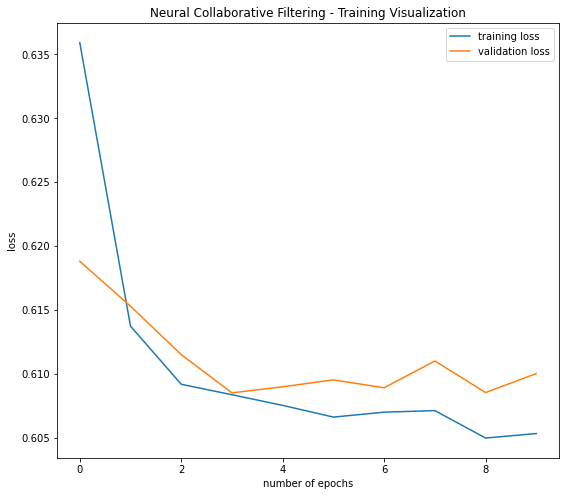

In [63]:
plt.figure(figsize = (9, 8))
plt.plot(training_history.history['loss'], label = 'training loss')
plt.plot(training_history.history['val_loss'], label = 'validation loss')

plt.title("Neural Collaborative Filtering - Training Visualization")
plt.legend(loc = 'best')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

In [71]:
# Get top 10 movie recommendations per user-
data_movie = pd.read_csv("ml-latest-small/movies.csv")

In [72]:
data_movie.shape

(9742, 3)

In [73]:
data_movie.isna().values.any()

False

In [74]:
data_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [75]:
data_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [81]:
# Get a random user for recommendation-
user_id = data_ratings['userId'].sample(1).iloc[0]

In [82]:
print(f"Random user ID = {user_id}")

Random user ID = 226


In [83]:
# Get a list of movies already watched by user-
movies_watched = data_ratings[data_ratings['userId'] == user_id]

In [84]:
movies_unwatched = data_movie[~data_movie['movieId'].isin(movies_watched['movieId'].values)]['movieId']

In [85]:
movies_watched.shape, movies_unwatched.shape

((507, 6), (9235,))

In [86]:
movies_unwatched = list(set(movies_unwatched).intersection(set(movie2movie_encoded.keys())))

In [87]:
movies_unwatched = [[movie2movie_encoded.get(x)] for x in movies_unwatched]

In [88]:
len(movies_unwatched)

9217

In [89]:
user_encoder = user2user_encoded.get(user_id)

In [90]:
user_movie_arr = np.hstack(
    ([[user_encoder]] * len(movies_unwatched), movies_unwatched)
)

In [92]:
recommendations = recommender.predict(user_movie_arr).flatten()

In [93]:
recommendations.shape

(9217,)

In [101]:
k = 10

In [102]:
top_ratings_indices = recommendations.argsort()[-k:][::-1]

In [103]:
recommended_movie_ids = [
    movie_encoded2movie.get(movies_unwatched[x][0]) for x in top_ratings_indices
]

In [106]:
print(f"Top recommendations for user ID: {user_id}:\n\n{data_movie[data_movie['movieId'].isin(recommended_movie_ids)]}")

Top recommendations for user ID: 226:

     movieId                             title                          genres
277      318  Shawshank Redemption, The (1994)                     Crime|Drama
686      904                Rear Window (1954)                Mystery|Thriller
909     1208             Apocalypse Now (1979)                Action|Drama|War
914     1213                 Goodfellas (1990)                     Crime|Drama
922     1221    Godfather: Part II, The (1974)                     Crime|Drama
926     1225                    Amadeus (1984)                           Drama
933     1233      Boot, Das (Boat, The) (1981)                Action|Drama|War
941     1242                      Glory (1989)                       Drama|War
944     1245          Miller's Crossing (1990)  Crime|Drama|Film-Noir|Thriller
947     1248              Touch of Evil (1958)        Crime|Film-Noir|Thriller


In [ ]:
Show top 10 movie recommendations to a user

movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
